2025-06-12 17:46:50,278 - INFO - Using device: cpu
2025-06-12 17:46:50,283 - INFO - Starting Neural Network model training...
2025-06-12 17:46:50,283 - INFO - Loading iFeature_AAC embeddings...
2025-06-12 17:46:50,284 - INFO - Loading and extracting features for aac from ../data/embeddings/iFeature_AAC.csv...
2025-06-12 17:46:50,295 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-06-12 17:46:50,296 - INFO - iFeature_AAC dimensions: (1720, 20)
2025-06-12 17:46:50,297 - INFO - Loading Kidera_encoded embeddings...
2025-06-12 17:46:50,297 - INFO - Loading and extracting features for kidera from ../data/embeddings/Kidera_encoded.csv...
2025-06-12 17:46:50,306 - INFO - Class distribution: Class 0: 859, Class 1: 861
2025-06-12 17:46:50,307 - INFO - Kidera_encoded dimensions: (1720, 10)
2025-06-12 17:46:50,307 - INFO - Loading BLOSUM62_encoded embeddings...
2025-06-12 17:46:50,307 - INFO - Loading and extracting features for blosum from ../data/embeddings/BLOSUM62_encoded.csv...
2

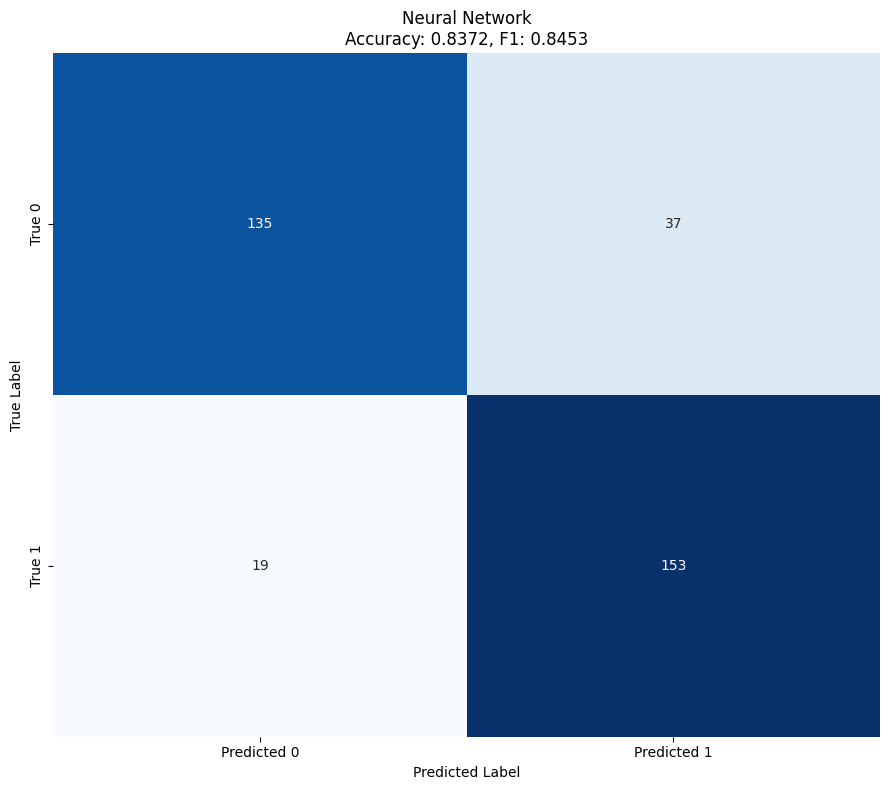

2025-06-12 17:46:59,647 - INFO - Neural Network model and artifacts saved to './nn_models'


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
import copy
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import os
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# --- Configuration ---
# Defines various parameters for data loading, model training, and hyperparameter grids.
config = {
    'aac_data_path': '../data/embeddings/iFeature_AAC.csv',
    'kidera_data_path': '../data/embeddings/Kidera_encoded.csv',
    'blosum_data_path': '../data/embeddings/BLOSUM62_encoded.csv',
    'intensity_threshold': 207500,
    'test_size': 0.2,
    'val_size': 0.2, # This is the validation size for the NN, taken from the train_val split
    'random_state': 42,
    'batch_size': 64,
    'epochs': 200,
    'patience': 30, # Early stopping patience
    'early_stopping_delta': 1e-6, # Minimum change in loss to qualify as an improvement
    'learning_rate': 0.001, # Initial learning rate for AdamW
    'min_lr': 1e-6, # Minimum LR for CyclicLR
    'max_lr': 0.01, # Maximum LR for CyclicLR
    'weight_decay': 1e-4, # L2 regularization for AdamW
    'hidden_dims_nn': [512, 256, 128, 64, 32], # Hidden layer dimensions for the NN
    'dropout_rates_nn': [0.5, 0.4, 0.3, 0.2, 0.1], # Dropout rates for NN layers
    'gradient_clip_norm': 1.0, # Gradient clipping to prevent exploding gradients
    'noise_magnitude': 0.03, # Magnitude of Gaussian noise for data augmentation
    'feature_selection_ratio': 0.8, # Ratio of features to select using SelectKBest
    'mixup_alpha': 0.2, # Alpha parameter for Mixup augmentation
    'ema_decay': 0.999, # Exponential Moving Average decay for NN weights
    'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Device for PyTorch (GPU/CPU)
    'lr_scheduler_type': 'cyclic', # Type of learning rate scheduler for NN ('cyclic' or 'plateau')
}

# --- Seed Setting ---
def set_seed(seed: int) -> None:
    """
    Sets the random seed for reproducibility across numpy, random, and torch.
    This ensures that results are consistent across multiple runs of the code
    when using random operations.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Initialize logging and device
set_seed(config['random_state'])
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
device = torch.device(config['device'])
logging.info(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
class FeatureDataset(Dataset):
    """
    Custom PyTorch Dataset for handling features and labels, with optional augmentation.
    This class provides a standard interface for PyTorch's DataLoader.
    """
    def __init__(self, features, labels, augment=False):
        self.features = features # Expects torch.Tensor features
        self.labels = labels     # Expects torch.Tensor labels
        self.augment = augment
        
    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.features)
    
    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the given index.
        Applies augmentation techniques (Gaussian noise, Mixup) if `self.augment` is True.
        """
        x = self.features[idx]
        y = self.labels[idx]
        
        if self.augment:
            # Add Gaussian noise to features for regularization and robustness
            noise = torch.randn_like(x) * config['noise_magnitude']
            x = x + noise
            
            # Mixup augmentation: blends the current sample with another random sample
            # This helps to regularize the model and improve generalization.
            if random.random() > 0.5 and config['mixup_alpha'] > 0:
                lam = np.random.beta(config['mixup_alpha'], config['mixup_alpha'])
                rand_idx = random.randint(0, len(self.features)-1)
                x2 = self.features[rand_idx]
                y2 = self.labels[rand_idx]
                x = lam * x + (1 - lam) * x2
                y = lam * y + (1 - lam) * y2
                
        return x, y

def load_and_extract_features(data_path: str, intensity_threshold: int, embedding_type: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Loads a CSV file containing embedding data, extracts relevant features,
    and creates a binary target variable based on a specified intensity threshold.
    """
    logging.info(f"Loading and extracting features for {embedding_type} from {data_path}...")
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        logging.error(f"Error: Data file not found at {data_path}. Please check the path.")
        sys.exit(1) # Exit if file is not found
    except Exception as e:
        logging.error(f"Error loading CSV file: {e}")
        sys.exit(1) # Exit on other CSV loading errors

    if df.empty:
        logging.error("Error: Loaded CSV file is empty. No data to process.")
        sys.exit(1) # Exit if DataFrame is empty

    # Feature column selection logic based on the type of embedding
    if embedding_type == 'aac':
        # For AAC, features are typically single-letter amino acid codes.
        # This checks for single-character column names that are uppercase letters.
        feature_columns = [col for col in df.columns if len(col) == 1 and 'A' <= col <= 'Z' and col not in ['B', 'J', 'O', 'U', 'X', 'Z']]
        if not feature_columns:
            logging.warning("No standard single-letter AAC columns found. Attempting to use all columns except 'Intensity'.")
            feature_columns = [col for col in df.columns if col != 'Intensity']
        X = df.loc[:, feature_columns].values.astype(np.float32)
    elif embedding_type == 'kidera':
        # For Kidera, features are typically named 'KF1' to 'KF10'.
        X = df.loc[:, "KF1": "KF10"].values.astype(np.float32)
    elif embedding_type == 'blosum':
        # For BLOSUM, features typically start with 'BLOSUM62_'.
        blosum_cols = [col for col in df.columns if col.startswith('BLOSUM62_')]
        X = df.loc[:, blosum_cols].values.astype(np.float32)
    else:
        logging.error(f"Unknown embedding_type: {embedding_type}. Supported types are 'aac', 'kidera', and 'blosum'.")
        sys.exit(1) # Exit on unknown embedding type

    if 'Intensity' not in df.columns:
        logging.error("Error: 'Intensity' column not found in the CSV. Required for target variable creation.")
        sys.exit(1) # Exit if 'Intensity' column is missing

    # Create binary target variable: 1 if intensity > threshold, 0 otherwise.
    y_class = (df['Intensity'] > intensity_threshold).astype(int).values
    class_counts = np.bincount(y_class)
    logging.info(f"Class distribution: Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

    return X, y_class

def select_features(X_train, y_train, X_val, X_test, k_ratio=0.8):
    """
    Performs feature selection using SelectKBest with mutual_info_classif as the scoring function.
    It fits the selector only on the training data to prevent data leakage,
    then transforms the training, validation, and test sets.
    """
    k = int(X_train.shape[1] * k_ratio) # Determine number of features to select based on ratio
    if k == 0: # Ensure at least one feature is selected if k_ratio leads to zero
        k = 1
    elif k > X_train.shape[1]: # Do not attempt to select more features than available
        k = X_train.shape[1]

    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    logging.info(f"Selected {k} features using mutual information from {X_train.shape[1]} original features")
    return X_train_selected, X_val_selected, X_test_selected, selector

def create_and_scale_splits(X: np.ndarray, y: np.ndarray, test_size: float, val_size: float, random_state: int) -> tuple:
    """
    Splits the combined data into overall training/validation, and test sets.
    A single StandardScaler is fitted on the overall training/validation set (X_train_val_raw)
    to ensure consistent scaling across all subsets (train, val, test) and prevent data leakage
    from the test set into the scaling process.
    """
    # 1. Split the data into an overall training/validation set and a final test set.
    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(sss_test.split(X, y))
    X_train_val_raw, X_test_raw = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # 2. Fit the StandardScaler ONLY on X_train_val_raw (the data that models will be trained on)
    # and then transform all subsets. This prevents data leakage from the test set.
    scaler = StandardScaler()
    X_train_val_scaled = scaler.fit_transform(X_train_val_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    # 3. Split the ALREADY SCALED X_train_val_scaled into Neural Network specific train and validation sets.
    # This split is also stratified to maintain class proportions.
    sss_nn_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    # y_train_val is used for stratification as it corresponds to X_train_val_scaled
    train_nn_idx, val_nn_idx = next(sss_nn_val.split(X_train_val_scaled, y_train_val))
    X_train_nn_scaled = X_train_val_scaled[train_nn_idx]
    X_val_nn_scaled = X_train_val_scaled[val_nn_idx]
    y_train_nn = y_train_val[train_nn_idx]
    y_val_nn = y_train_val[val_nn_idx]

    logging.info(f"NN Train dataset size: {len(X_train_nn_scaled)}")
    logging.info(f"NN Validation dataset size: {len(X_val_nn_scaled)}")
    logging.info(f"Final Test dataset size: {len(X_test_scaled)}")
    logging.info("Data scaled using StandardScaler (fitted on combined train+val data)")
    
    # Return all necessary splits and the fitted scaler
    return (X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn, 
            X_test_scaled, y_test, scaler, X_train_val_scaled, y_train_val)


# --- Neural Network Architecture with Improvements ---
class ResidualBlock(nn.Module):
    """
    A Residual Block implementation for the neural network.
    It includes two linear layers, Batch Normalization, Dropout for regularization,
    and Swish (SiLU) activation function, along with a shortcut connection.
    """
    def __init__(self, in_dim, out_dim, dropout_rate):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)
        # The shortcut connection ensures that the input can bypass certain layers,
        # helping with gradient flow and training of deeper networks.
        # If input and output dimensions differ, a linear projection is used for the shortcut.
        self.shortcut = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        
    def forward(self, x):
        identity = self.shortcut(x) # Preserve input for the shortcut connection
        out = self.linear1(x)
        out = self.bn1(out)
        out = F.silu(out)  # Swish (SiLU) activation for non-linearity
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += identity # Add the shortcut connection output to the main path output
        return F.silu(out) # Final activation for the block

class AttentionPooling(nn.Module):
    """
    Implements a simple attention mechanism to weigh features within a sample.
    Instead of summing, it produces a re-weighted feature vector where important features
    are emphasized. This is done by learning attention scores for each feature
    and then applying these scores as weights.
    """
    def __init__(self, feature_dim):
        super().__init__()
        # This sequential block generates raw attention scores for each feature.
        # It takes an input of shape (batch_size, feature_dim) and outputs
        # raw scores of the same shape.
        self.attention_score_generator = nn.Sequential(
            nn.Linear(feature_dim, feature_dim), # Linear transformation of features
            nn.Tanh(),                           # Non-linearity to introduce complexity
            nn.Linear(feature_dim, feature_dim)  # Another linear layer to output scores per feature
        )
        
    def forward(self, x):
        # x has shape (batch_size, feature_dim), e.g., (64, 32) if feature_dim is 32
        raw_attention_scores = self.attention_score_generator(x) # Output also (batch_size, feature_dim)
        
        # Apply softmax across the feature dimension (dim=1) to normalize scores into
        # attention weights that sum to 1 for each sample.
        attention_weights = F.softmax(raw_attention_scores, dim=1) # (batch_size, feature_dim)
        
        # Perform element-wise multiplication: re-weights the original features by attention weights.
        # This results in an "attended" feature vector, highlighting important features.
        attended_features = x * attention_weights # (batch_size, feature_dim)
        
        return attended_features # The output dimension is preserved to match the next layer's input.


class ClassifierNN(nn.Module):
    """
    A multi-layer Neural Network Classifier using Residual Blocks and an Attention Pooling layer.
    Designed for binary classification. Includes Exponential Moving Average (EMA)
    for model weights, which can help stabilize training and improve performance.
    """
    def __init__(self, input_dim: int, hidden_dims: list[int], dropout_rates: list[float]):
        super(ClassifierNN, self).__init__()
        layers = []
        
        # Initial projection layer to map input features to the first hidden dimension.
        self.input_proj = nn.Linear(input_dim, hidden_dims[0])
        
        # Stack Residual Blocks as defined above. Each block processes and transforms features.
        for i in range(len(hidden_dims)-1):
            layers.append(ResidualBlock(hidden_dims[i], hidden_dims[i+1], dropout_rates[i]))
        
        self.res_blocks = nn.Sequential(*layers) # Group residual blocks into a sequential module
        
        # The Attention Pooling layer processes the output of the last residual block.
        # It helps the model focus on the most relevant features before the final classification.
        self.attention = AttentionPooling(hidden_dims[-1])
        
        # Final output layer for binary classification. It projects the attended features
        # to a single output (logit). Sigmoid activation is applied externally (e.g., in BCEWithLogitsLoss).
        self.out = nn.Linear(hidden_dims[-1], 1)
        
        # EMA model is a copy of the main model, but its weights are updated smoothly
        # (exponentially decaying average) during training. It's often used for inference
        # as it can provide more stable and often better predictions.
        self.ema_model = copy.deepcopy(self)
        for param in self.ema_model.parameters():
            param.requires_grad = False # EMA model parameters should not be updated by gradient descent directly

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the neural network.
        Input `x` is the feature tensor.
        Returns the raw logits for binary classification.
        """
        x = F.silu(self.input_proj(x)) # Apply initial projection and Swish activation
        x = self.res_blocks(x)         # Pass through the sequence of residual blocks
        x = self.attention(x)          # Apply attention pooling to the features
        return self.out(x)             # Output the final logits
    
    def update_ema(self, decay=0.999):
        """
        Updates the weights of the EMA model.
        The EMA weights are a weighted average of the current model's weights and previous EMA weights.
        """
        with torch.no_grad(): # No gradient calculation needed for EMA update
            for param, ema_param in zip(self.parameters(), self.ema_model.parameters()):
                ema_param.data = decay * ema_param.data + (1 - decay) * param.data

# --- Early Stopping Helper Class ---
class EarlyStopping:
    """
    A utility class for implementing early stopping during model training.
    It monitors a specified validation metric (e.g., validation loss) and
    stops training if the metric does not improve for a predefined number of epochs (patience).
    It also saves the best model weights observed so far.
    """
    def __init__(self, patience: int = 10, delta: float = 0.0):
        self.patience = patience
        self.delta = delta # Minimum change in the monitored quantity to qualify as an improvement.
        self.best_loss = float('inf') # Initialize with a very large number for comparison
        self.counter = 0 # Counter for epochs without improvement
        self.best_model_wts = None # To store the state dictionary of the best model
        self.early_stop = False # Flag to indicate if early stopping should be triggered

    def __call__(self, val_loss: float, model: nn.Module) -> bool:
        """
        Call method to update the early stopping status based on the current validation loss.
        """
        if val_loss < self.best_loss - self.delta: # If current loss is an improvement over the best
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict()) # Save a deep copy of the model's current weights
            self.counter = 0 # Reset the patience counter
        else: # If loss does not improve (or improvement is less than delta)
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True # Trigger early stopping
        return self.early_stop

    def load_best_weights(self, model: nn.Module) -> None:
        """
        Loads the best saved model weights back into the provided model.
        This is typically called after training completes (either by reaching max epochs or early stopping).
        """
        if self.best_model_wts:
            model.load_state_dict(self.best_model_wts)
            logging.info("Loaded best model weights based on validation loss.")
        else:
            logging.warning("No best model weights saved, possibly due to training not starting or errors.")

# --- Learning Rate Finder (utility, not used in main execution by default) ---
def find_learning_rate(model, train_loader, criterion, optimizer, device, min_lr=1e-7, max_lr=1, num_iters=100):
    """
    Performs a learning rate range test. This utility function helps to identify
    a good range for learning rates by incrementally increasing the LR and observing the loss.
    It's not used in the main training loop but can be helpful for hyperparameter tuning.
    """
    model.train()
    # Calculate the multiplicative factor to increase LR exponentially over num_iters
    lr_mult = (max_lr / min_lr) ** (1/num_iters) 
    lr = min_lr
    optimizer.param_groups[0]['lr'] = lr # Set the initial learning rate
    
    losses = []
    lrs = []
    
    for i, (inputs, targets) in enumerate(train_loader):
        if i >= num_iters:
            break # Stop after the specified number of iterations
            
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # Clear gradients from the previous step
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets.float())
        
        # Backpropagate the loss and update model weights
        loss.backward()
        optimizer.step()
        
        # Update learning rate for the next iteration
        lr *= lr_mult
        optimizer.param_groups[0]['lr'] = lr
        
        # Record loss and learning rate for plotting/analysis
        losses.append(loss.item())
        lrs.append(lr)
        
    return lrs, losses

# --- Training and Evaluation Functions ---
def train_nn_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    early_stopper: EarlyStopping,
    epochs: int,
    device: torch.device,
    gradient_clip_norm: float
) -> nn.Module:
    """
    Orchestrates the training process for the neural network model.
    Includes iterative training, validation, learning rate scheduling,
    gradient clipping, and early stopping.
    """
    logging.info(f"Starting Neural Network training for up to {epochs} epochs...")
    best_epoch = 0 # Tracks the epoch where the best validation loss was achieved
    
    for epoch in range(1, epochs + 1):
        model.train() # Set the model to training mode (enables dropout, BatchNorm updates)
        current_train_loss = 0.0
        # tqdm provides a progress bar for iterables, useful for long training loops.
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for xb, yb in progress_bar:
            xb, yb = xb.to(device), yb.to(device) # Move batch data to the specified device (CPU/GPU)
            optimizer.zero_grad() # Reset gradients to zero before backpropagation
            preds = model(xb).squeeze() # Perform a forward pass, .squeeze() removes singleton dimensions
            loss = criterion(preds, yb.float()) # Calculate the loss (e.g., BCEWithLogitsLoss)
            loss.backward() # Compute gradients based on the loss
            
            # Apply gradient clipping to prevent exploding gradients, which can destabilize training.
            if gradient_clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_norm)
                
            optimizer.step() # Update model parameters using the computed gradients
            model.update_ema(config['ema_decay']) # Update the Exponential Moving Average weights
            
            current_train_loss += loss.item() * xb.size(0) # Accumulate weighted loss for epoch average
            progress_bar.set_postfix(loss=loss.item()) # Display current batch loss in the progress bar
            
        current_train_loss /= len(train_loader.dataset) # Calculate average training loss for the epoch

        # Validation phase: evaluate model performance on unseen data
        model.eval() # Set the model to evaluation mode (disables dropout, BatchNorm uses running stats)
        current_val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation for validation (saves memory and speeds up)
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).squeeze()
                loss = criterion(preds, yb.float())
                current_val_loss += loss.item() * xb.size(0)
        current_val_loss /= len(val_loader.dataset) # Calculate average validation loss for the epoch

        # Step the learning rate scheduler
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(current_val_loss) # ReduceLROnPlateau adjusts LR based on validation loss
        else:
            scheduler.step() # Other schedulers (like CyclicLR) might step per epoch or iteration

        logging.info(f"  NN Epoch {epoch}/{epochs} - Train Loss: {current_train_loss:.4f}, Val Loss: {current_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Check early stopping criteria
        if early_stopper(current_val_loss, model):
            logging.info(f"  NN Early stopping triggered at epoch {epoch}. Restoring best model weights.")
            best_epoch = epoch
            break # Exit the training loop if early stopping condition is met
            
        if epoch == epochs: # If training completes all specified epochs without early stopping
            best_epoch = epoch

    # After the training loop, load the best model weights saved by the early stopper.
    early_stopper.load_best_weights(model) 
    logging.info(f"Training completed. Best epoch: {best_epoch}")
    return model

def evaluate_classifier_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray = None, model_name: str = "Model") -> tuple:
    """
    Calculates and logs a comprehensive set of classification performance metrics,
    including accuracy, F1-score, precision, recall, ROC AUC, and the confusion matrix.
    """
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    roc_auc = np.nan # Initialize ROC AUC as NaN; it will be computed if probabilities are available
    if y_prob is not None and len(np.unique(y_true)) > 1: # ROC AUC requires probabilities and at least two classes
        try:
            roc_auc = roc_auc_score(y_true, y_prob)
        except ValueError as e:
            logging.warning(f"Error computing ROC AUC for {model_name}: {e}") # Log a warning if computation fails

    logging.info(f"\n--- {model_name} Results ---")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"F1-score: {f1:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"ROC AUC: {roc_auc:.4f}")
    logging.info(f"Confusion Matrix:\n{cm}")

    return accuracy, f1, precision, recall, roc_auc, cm

def plot_roc_curve(y_true: np.ndarray, y_prob: np.ndarray, model_name: str, save_path: str) -> None:
    """
    Plots the Receiver Operating Characteristic (ROC) curve and saves it to a file.
    """
    if len(np.unique(y_true)) < 2:
        logging.warning(f"Cannot plot ROC curve for {model_name}: Only one class present in y_true.")
        return

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(save_path)
    logging.info(f"ROC curve for {model_name} saved to '{save_path}'")
    plt.close() # Close the plot to free memory


# --- Main Script Execution ---
def main():
    logging.info("Starting Neural Network model training...")

    # --- Data Loading ---
    # Load feature embeddings from different sources. Each embedding type (AAC, Kidera, BLOSUM)
    # provides a different representation of the input data, potentially capturing diverse patterns.
    logging.info("Loading iFeature_AAC embeddings...")
    X_aac, y_class_aac = load_and_extract_features(config['aac_data_path'], config['intensity_threshold'], 'aac')
    logging.info(f"iFeature_AAC dimensions: {X_aac.shape}")

    logging.info("Loading Kidera_encoded embeddings...")
    X_kidera, y_class_kidera = load_and_extract_features(config['kidera_data_path'], config['intensity_threshold'], 'kidera')
    logging.info(f"Kidera_encoded dimensions: {X_kidera.shape}")

    logging.info("Loading BLOSUM62_encoded embeddings...")
    X_blosum, y_class_blosum = load_and_extract_features(config['blosum_data_path'], config['intensity_threshold'], 'blosum')
    logging.info(f"BLOSUM62_encoded dimensions: {X_blosum.shape}")

    # Verify that the target variables extracted from all embedding files are identical.
    # This is crucial for ensuring data alignment across different feature sets.
    if not (np.array_equal(y_class_aac, y_class_kidera) and np.array_equal(y_class_aac, y_class_blosum)):
        logging.error("Target variables from different embeddings are not identical. Check input data alignment.")
        sys.exit(1) # Exit if misalignment is detected
    y_class = y_class_aac # Use one of them as the definitive target variable

    # Combine all feature sets horizontally (concatenate columns).
    # This creates a comprehensive feature vector for each sample.
    X_combined = np.hstack((X_aac, X_kidera, X_blosum))
    logging.info(f"Combined feature dimensions: {X_combined.shape}")

    # --- Data Splitting and Scaling ---
    # Split the combined data into training, validation, and test sets.
    # Scaling is applied based on the training data only to prevent data leakage.
    (X_train_nn_scaled, y_train_nn, X_val_nn_scaled, y_val_nn, 
     X_test_scaled, y_test, scaler_global, _, _) = \
        create_and_scale_splits(X_combined, y_class, config['test_size'], config['val_size'], config['random_state'])

    # --- Feature Selection ---
    # Apply feature selection using mutual information to reduce dimensionality and noise.
    # The selector is fitted on the neural network's training data.
    X_train_nn_selected, X_val_nn_selected, X_test_selected, feature_selector = \
        select_features(X_train_nn_scaled, y_train_nn, X_val_nn_scaled, X_test_scaled, 
                        config['feature_selection_ratio'])
    
    input_dim_selected = X_train_nn_selected.shape[1] # The effective input dimension for the NN

    # --- PyTorch DataLoader Preparation for Neural Network ---
    # Convert NumPy arrays to PyTorch tensors and create datasets.
    tensor_X_train_nn = torch.tensor(X_train_nn_selected, dtype=torch.float32)
    tensor_y_train_nn = torch.tensor(y_train_nn, dtype=torch.float32)
    tensor_X_val_nn = torch.tensor(X_val_nn_selected, dtype=torch.float32)
    tensor_y_val_nn = torch.tensor(y_val_nn, dtype=torch.float32)
    tensor_X_test = torch.tensor(X_test_selected, dtype=torch.float32)
    tensor_y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create PyTorch datasets, applying augmentation to the training data.
    train_nn_ds = FeatureDataset(tensor_X_train_nn, tensor_y_train_nn, augment=True)
    val_nn_ds = TensorDataset(tensor_X_val_nn, tensor_y_val_nn)
    test_nn_ds = TensorDataset(tensor_X_test, tensor_y_test)

    # Create DataLoaders for efficient batching and shuffling of data during training.
    train_nn_loader = DataLoader(train_nn_ds, batch_size=config['batch_size'], shuffle=True)
    val_nn_loader = DataLoader(val_nn_ds, batch_size=config['batch_size'], shuffle=False)
    test_nn_loader = DataLoader(test_nn_ds, batch_size=config['batch_size'], shuffle=False)

    # --- Neural Network Model Training ---
    # Calculate class weights for the BCEWithLogitsLoss. This is important for
    # handling imbalanced datasets by giving more importance to the minority class.
    count_class_0 = np.sum(y_train_nn == 0)
    count_class_1 = np.sum(y_train_nn == 1)
    pos_weight = count_class_0 / count_class_1 if count_class_1 > 0 else 1.0
    logging.info(f"Positive class weight for NN: {pos_weight:.4f}")

    # Initialize the Neural Network model, loss function, and optimizer.
    nn_model = ClassifierNN(input_dim_selected, config['hidden_dims_nn'], config['dropout_rates_nn']).to(device)
    nn_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    nn_optimizer = torch.optim.AdamW(nn_model.parameters(), lr=config['learning_rate'], 
                                     weight_decay=config['weight_decay'])

    # Initialize the learning rate scheduler based on the configuration.
    if config['lr_scheduler_type'] == 'cyclic':
        nn_scheduler = CyclicLR(nn_optimizer, base_lr=config['min_lr'], max_lr=config['max_lr'],
                                step_size_up=2000, cycle_momentum=False)
        logging.info("Using CyclicLR learning rate scheduler")
    else: # Default to ReduceLROnPlateau
        nn_scheduler = ReduceLROnPlateau(nn_optimizer, 'min', patience=config['patience']//2, 
                                         factor=0.5, verbose=True)
        logging.info("Using ReduceLROnPlateau learning rate scheduler")

    # Initialize early stopping to prevent overfitting.
    nn_early_stopper = EarlyStopping(patience=config['patience'], delta=config['early_stopping_delta'])

    # Train the neural network model.
    best_nn_model = train_nn_model(
        nn_model, train_nn_loader, val_nn_loader, nn_criterion,
        nn_optimizer, nn_scheduler, nn_early_stopper,
        config['epochs'], device, config['gradient_clip_norm']
    )

    # Evaluate the trained neural network on the test set.
    best_nn_model.eval() # Set the model to evaluation mode for inference
    nn_test_probs_list = []
    with torch.no_grad(): # Disable gradient calculation for efficient inference
        for xb, _ in test_nn_loader:
            xb = xb.to(device)
            outputs = best_nn_model(xb).squeeze()
            nn_test_probs_list.extend(torch.sigmoid(outputs).cpu().numpy()) # Convert logits to probabilities
    nn_test_probs = np.array(nn_test_probs_list)
    nn_test_preds = (nn_test_probs > 0.5).astype(int) # Convert probabilities to binary predictions

    nn_acc, nn_f1, nn_prec, nn_rec, nn_roc_auc, nn_cm = evaluate_classifier_metrics(
        y_test, nn_test_preds, nn_test_probs, "Neural Network (Test)"
    )
    # Plot ROC curve for NN
    plot_roc_curve(y_test, nn_test_probs, "Neural Network", './images/roc_curve_nn.png')

    # --- Visualization: Confusion Matrices ---
    # Plot confusion matrix for the trained NN model
    fig, axes = plt.subplots(1, 1, figsize=(9, 8)) # Create a single subplot for NN
    
    sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['True 0', 'True 1'], ax=axes)
    axes.set_xlabel("Predicted Label")
    axes.set_ylabel("True Label")
    axes.set_title(f"Neural Network\nAccuracy: {nn_acc:.4f}, F1: {nn_f1:.4f}")
    
    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plot_save_path = './images/confusion_matrix_nn.png'
    plt.savefig(plot_save_path) # Save the generated plot to a file
    logging.info(f"Confusion matrix for Neural Network saved to '{plot_save_path}'")
    plt.show() # Display the plot

    # --- Model Saving ---
    # Save the trained NN model, the scaler, and the feature selector for future use
    models_dir = './nn_models' # Dedicated directory for NN models
    os.makedirs(models_dir, exist_ok=True) # Create the directory if it doesn't already exist
    
    torch.save(best_nn_model.state_dict(), os.path.join(models_dir, 'best_nn_model.pt'))
    joblib.dump(scaler_global, os.path.join(models_dir, 'scaler.pkl')) # Save the data scaler
    joblib.dump(feature_selector, os.path.join(models_dir, 'feature_selector.pkl')) # Save the feature selector
    
    logging.info(f"Neural Network model and artifacts saved to '{models_dir}'")

if __name__ == "__main__":
    main()
